# Interpretting Different Models
AutoML | H2O | Regression | GBM | XGBoost | Python | Jupyter Notebook

## Abstract
In this project, we will be using the [USDA Food Composition Databases](https://fdc.nal.usda.gov/) dataset to predict the number of calories in a food given its nutritional information. We will use 3 techniques to fit a model to our data and interpret the results.
1. Linear Regression (OLS)
2. Tree-Based Model (XGBoost)
3. Best AutoML Model (GBM)

We then use each models Shapley Additive Explanation (SHAP) to compare model features in the same terms to discover. Of the models trained in this project, 

In [1]:
import pydot
import xgboost
# Importing necessary libraries
!pip install --upgrade pip
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install shap
!pip install xgboost
!pip install graphviz
!pip install gbm

In [2]:
!pip3 install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [119]:
!pip install graphviz
!pip install matplotlib 
!pip install pygraphviz


  Using cached pygraphviz-1.11.zip (120 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [52 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-universal2-cpython-310
      creating build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      copying pygraphviz/scraper.py -> build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      copying pygraphviz/graphviz.py -> build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      copying pygraphviz/__init__.py -> build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      copying pygraphviz/agraph.py -> build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      copying pygraphviz/testing.py -> build/lib.macosx-10.9-universal2-cpython-310/pygraphviz
      creating build/lib.macosx-10.9-universal2-cpython-310/pygraphviz/test

In [3]:
import h2o
# Importing necessary libraries
from h2o.automl import H2OAutoML
import random, os, sys
import psutil
import random
import logging
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [4]:
min_mem_size=6 
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [5]:
port_no=random.randint(5555,55555)
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)    
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:41111..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4" 2022-07-19; OpenJDK Runtime Environment Temurin-17.0.4+8 (build 17.0.4+8); OpenJDK 64-Bit Server VM Temurin-17.0.4+8 (build 17.0.4+8, mixed mode)
  Starting server from /Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmppu1u1a0k
  JVM stdout: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmppu1u1a0k/h2o_vraosharma_started_from_python.out
  JVM stderr: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmppu1u1a0k/h2o_vraosharma_started_from_python.err
  Server is running at http://127.0.0.1:41111
Connecting to H2O server at http://127.0.0.1:41111 ... successful.


--------------------------  ---------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.1
H2O_cluster_version_age:    1 month and 11 days
H2O_cluster_name:           H2O_from_python_vraosharma_bokw79
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:41111
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.6 final
--------------------------  ---------------------------------

## Importing the dataset

In [6]:
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vishnuraosharma/exploratory-data-analysis/main/Kcal%20Predictions/food.csv

zsh:1: command not found: wget


In [7]:
#Reading the file into a dataframe and viewing the first few rows
dff = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in dff.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    dff.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
dff.describe()

Nutrient Data Bank Number  Alpha Carotene          Ash  Beta Carotene  \
count                7413.000000     7413.000000  7413.000000    7413.000000   
mean                14116.443680       21.210711     1.852459     159.043437   
std                  8767.416214      269.714183     2.993228    1126.285026   
min                  1001.000000        0.000000     0.000000       0.000000   
25%                  8121.000000        0.000000     0.830000       0.000000   
50%                 12539.000000        0.000000     1.240000       0.000000   
75%                 18424.000000        0.000000     2.200000       1.000000   
max                 93600.000000    14251.000000    99.800000   42891.000000   

       Beta Cryptoxanthin  Carbohydrate  Cholesterol      Choline  \
count         7413.000000   7413.000000  7413.000000  7413.000000   
mean             8.776744     21.785381    37.162822    20.673546   
std            154.184860     27.123491   119.738438    45.481990   
min              0.000000      0.000000     0.000000     0.000000   
25%              0.000000      0.490000     0.000000     0.000000   
50%              0.000000      9.290000     2.000000     0.000000   
75%              0.000000     30.590000    60.000000    20.000000   
max           7923.000000    100.000000  3100.000000  1388.000000   

             Fiber  Kilocalories  ...  Major Minerals.Potassium  \
count  7413.000000   7413.000000  ...               7413.000000   
mean      1.993147    219.655875  ...                268.348172   
std       4.292873    171.668713  ...                404.916220   
min       0.000000      0.000000  ...                  0.000000   
25%       0.000000     82.000000  ...                103.000000   
50%       0.300000    181.000000  ...                210.000000   
75%       2.300000    331.000000  ...                328.000000   
max      79.000000    902.000000  ...              16500.000000   

       Major Minerals.Sodium  Major Minerals.Zinc  Vitamins.Vitamin A - IU  \
count            7413.000000          7413.000000              7413.000000   
mean              331.590719             1.875125               767.568191   
std               977.046544             4.193682              3871.307652   
min                 0.000000             0.000000                 0.000000   
25%                31.000000             0.190000                 0.000000   
50%                86.000000             0.770000                33.000000   
75%               428.000000             2.460000               280.000000   
max             38758.000000           181.610000            100000.000000   

       Vitamins.Vitamin A - RAE  Vitamins.Vitamin B12  Vitamins.Vitamin B6  \
count               7413.000000           7413.000000          7413.000000   
mean                  99.437070              1.172903             0.269547   
std                  761.653061              4.512816             0.565116   
min                    0.000000              0.000000             0.000000   
25%                    0.000000              0.000000             0.030000   
50%                    0.000000              0.010000             0.110000   
75%                   24.000000              0.830000             0.330000   
max                30000.000000             98.890000            12.000000   

       Vitamins.Vitamin C  Vitamins.Vitamin E  Vitamins.Vitamin K  
count         7413.000000         7413.000000         7413.000000  
mean             9.075651            0.842837            9.448604  
std             63.443284            4.169756           66.067619  
min              0.000000            0.000000            0.000000  
25%              0.000000            0.000000            0.000000  
50%              0.000000            0.050000            0.000000  
75%              3.500000            0.390000            1.700000  
max           2400.000000          149.400000         1714.500000  

[8 rows x 44 columns]

## Data Preprocessing

Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

Furthermore, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [8]:
# Drop 'Household Weight Description' columns
dff.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

# Drop rows where Household Weights.1st Household Weight is 0
dff = dff[dff['Household Weights.1st Household Weight'] != 0]

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [9]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
dff.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Looking at the means, std. deviations, mins, and maxes, of each of our fields we can see that our data needs to be evaluated column by column to determine if each field makes sense. At face value, a mean of 21.8 for Carbohydrates and 37.2 for Cholesterol seems off, but we need to consider the units of each column. 

Of course, we will treat the Data Bank Number as a surrogate key and disregard its distribution. Similarly, Category and Description are categorical variables and we will them in our unit analysis.

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
1. Ash: g
2. Alpha Carotene: µg
3. Beta Carotene: µg
4. Beta Cryptoxanthin: µg
5. Carbohydrate: g
6. Cholesterol: mg
7. Choline: mg
8. Fat.Monosaturated Fat: g
9. Fat.Polysaturated Fat: g
10. Fat.Saturated Fat: g
11. Fat.Total Lipid: g
12. Fiber: g
13. Household Weights.1st Household Weight: g
14. Kilocalories: kcal
15. Lutein and Zeaxanthin: µg
16. Lycopene: µg
17. Major Minerals.Calcium: mg
18. Major Minerals.Copper: mg
19. Major Minerals.Iron: mg
20. Major Minerals.Magnesium: mg
21. Major Minerals.Phosphorus: mg
22. Major Minerals.Potassium: mg
23. Major Minerals.Sodium: mg
24. Major Minerals.Zinc: mg
25. Manganese: mg
26. Niacin: mg
27. Pantothenic Acid: mg
28. Protein: g
29. Refuse Percentage: % by volume
30. Retinol: µg
31. Riboflavin: mg
32. Selenium: µg
33. Sugar Total: g
34. Thiamin: mg
35. Vitamins.Vitamin A - RAE: µg
36. Vitamins.Vitamin B12: µg
37. Vitamins.Vitamin B6: µg
38. Vitamins.Vitamin C: µg
39. Vitamins.Vitamin E: mg
40. Vitamins.Vitamin K: µg
41. Water: g

Taking a look at the data again, everything seems to make sense. I find it a little strange that the Carbohydrate standard deviation is so high, but that could be because variety of foods in the dataset.

Also, though most of these fields are self-explanatory, I'll provide a quick definition for the ones that aren't:
* **Ash**: The inorganic residue remaining after the water and organic matter have been removed by heating in the presence of oxidizing agents, which provides a measure of the total amount of minerals within a food.
* **Refuse Percentage**: The percentage of a food that is not normally consumed, e.g. bones, shells, seeds, etc.
* **Retinol**: A form of Vitamin A.

As a final note, I will not be translating categorical data found in the *Categgory* column into a set of dummy variables because categorization is arbitrary. For example, the column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I could clean this up by introducing a new roll-up category, but this is beyond the scope of this project.

To practice working with dummy variables, however, I will remove the *Vitamins.Vitamin B12* column because, as we can see below, it has the lowest correlation with Kilocalories of all the Vitamins. I'll then add a dummy variable for the column. 

Finally, let's drop the *Data Bank Number* column because it is a surrogate key and the *Category* and *Description* columns because they are categorical variables that we are not going to be using in our model.

In [10]:
# Drop the 'Data Bank Number', 'Category', and 'Description' columns
dff.drop(['Category', 'Description', 'Nutrient Data Bank Number'], axis=1, inplace=True)

## Train Test Split
Let's load the pre-processed data into an H2O frame and split it up into training and test sets. We will use 80% of the data for training. 

Remember, our predictors will be all the remaining columns except for *Kilocalories*, our response variable. Because I'm using a variety of libraries to fit models, I will convert the H2O frame to a pandas dataframe after splitting the data into training and test sets.

In [11]:
# Show initial shape of dataframe
print('Initial shape of dataframe:', dff.shape)

Initial shape of dataframe: (6943, 41)


In [77]:
# Convert the dataframe to an H2OFrame
df = h2o.H2OFrame(dff)

# Splitting the data into training and test sets
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows], seed = 1)

# Show shape of training set and test set
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

# Save the h2o frames back to a pandas dataframe
df_train_pd = df_train.as_data_frame()
df_test_pd = df_test.as_data_frame()

print('Training pd set shape:', df_train_pd.shape)
print('Test pd set shape:', df_test_pd.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (5568, 41)
Test set shape: (1375, 41)
Training pd set shape: (5568, 41)
Test pd set shape: (1375, 41)


In [13]:
# Setting the predictor and response variables
y = 'Kilocalories'
X = list(df.columns)
X.remove(y)

# Print predictors
print('Predictors:', X)

# Print response variable
print('Response:', y)

Predictors: ['Alpha Carotene', 'Ash', 'Beta Carotene', 'Beta Cryptoxanthin', 'Carbohydrate', 'Cholesterol', 'Choline', 'Fiber', 'Lutein and Zeaxanthin', 'Lycopene', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Protein', 'Refuse Percentage', 'Retinol', 'Riboflavin', 'Selenium', 'Sugar Total', 'Thiamin', 'Water', 'Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Fat.Total Lipid', 'Household Weights.1st Household Weight', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B12', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K']
Response: Kilocalories


## Interpretting Feature Significance
Let's use 3 techniques to fit a model to our data and review some non-Shapley plots and statistics to interpret the results:
1. Linear Regression
2. Tree-Based Model
3. AutoML

### Linear Regression
Let's start by fitting a linear regression model to our data. We will use the sklearn library to fit the model and then use statsmodels.api to print a summary() method to view the results.

In [78]:
# Fit a linear regression model with default settings to training data with sklearn
from sklearn.linear_model import LinearRegression

# Create linear regression object
lm = LinearRegression()

# Train the model using the training sets
lm.fit(df_train_pd[X], df_train_pd[y])

# Save lm as an OLS model for summary() method
lm = sm.OLS(df_train_pd[y], df_train_pd[X]).fit()

# Print the summary of the model
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:           Kilocalories   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          4.061e+04
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:13:46   Log-Likelihood:                         -23445.
No. Observations:                5568   AIC:                                  4.697e+04
Df Residuals:                    5528   BIC:                                  4.723e+04
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

Considering the P values of <0.05 tell us that the probability of a feature being uncorrelated to our target is low, the OLS regression method tells us the following about our predictors:

1. *Fat.Total Lipid* is the most important predictor of Kilocalories, followed by Protein and Carbohydrates. Of course, we expect our macronutrients to drive the majority of calories.
2. When it comes to negative predictors of Kilocalories, *Fiber* overindexes other features. Fiborous vegetables are low in calories, so this makes sense.
3. Surprisingly, *Water* is just barely significant. This is likely because the majority of foods are mostly water, so it is not a good predictor of Kilocalories. Also, foods like soups and stews are mostly water and have a lot of calories, so this may be why the coefficient is negative.
4. Also unexpectedly, *Sugar Total* has a relatively low coefficient and high p-value. This is likely because sugar is a type of carbohydrate and is already accounted for in the *Carbohydrate* feature.

## Tree-Based Model
For our Tree-Based Model, we will use the Gradient Boosting Machine (GBM) algorithm. We will use the AutoML library to fit the model and then use the summary() method to view the results.

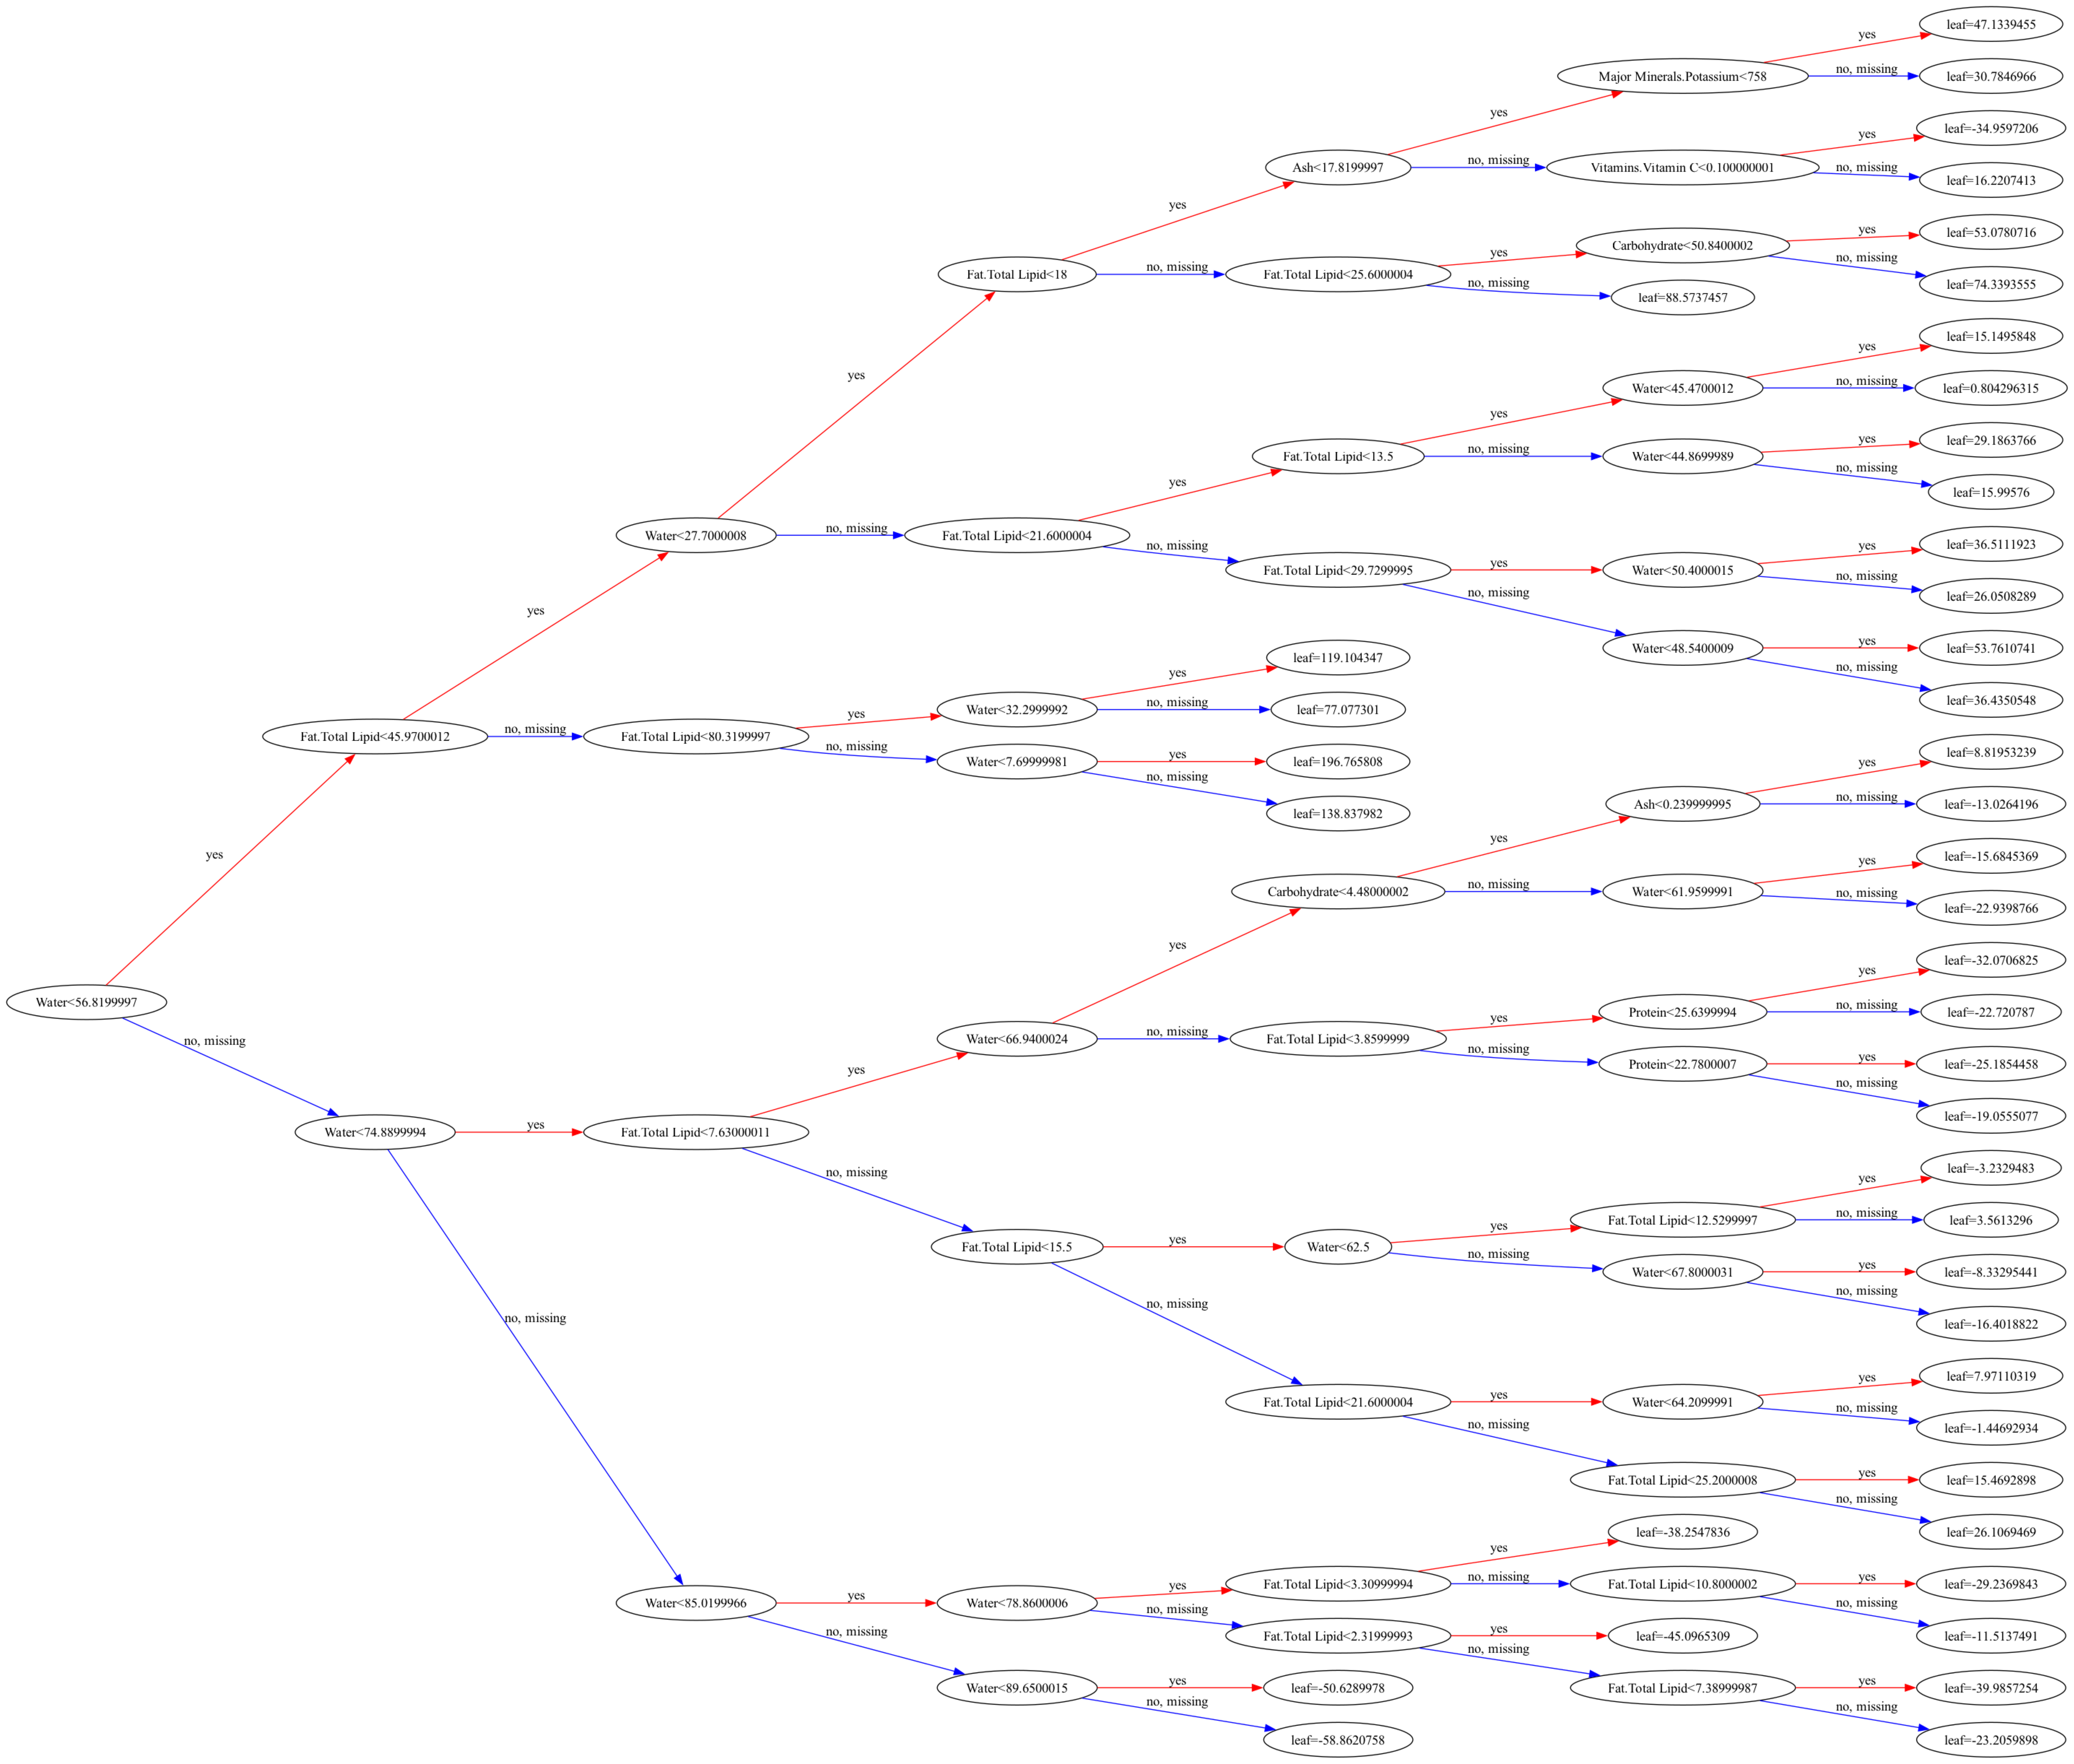

In [128]:
# Create an xgboost model
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree

# Create and train the XGBoost model
xgbm = XGBRegressor()
xgbm.fit(df_train_pd[X], df_train_pd[y])

# Get booster
booster = xgbm.get_booster()
tree_dump = booster.get_dump()

# Plot the tree
fig, ax = plt.subplots(figsize=(150, 80))
plot_tree(booster, num_trees=0, ax=ax, rankdir='LR')
plt.show()

A tree seems like it'd be a very useful tool for this problem with a few features. Each node would help eaters make clear choices: the high fat branch is leading me to leaves with higher calories, for example. However, the unrpruned tree above is very large and difficult to interpret. We see that Water is a top level feature, but as we traverse through the high-water-content side of the graph, we see a wide range of calorie totals. We seem to be overfitting. Let's see the variable importance plot to get a better idea of what features are most important to the model.

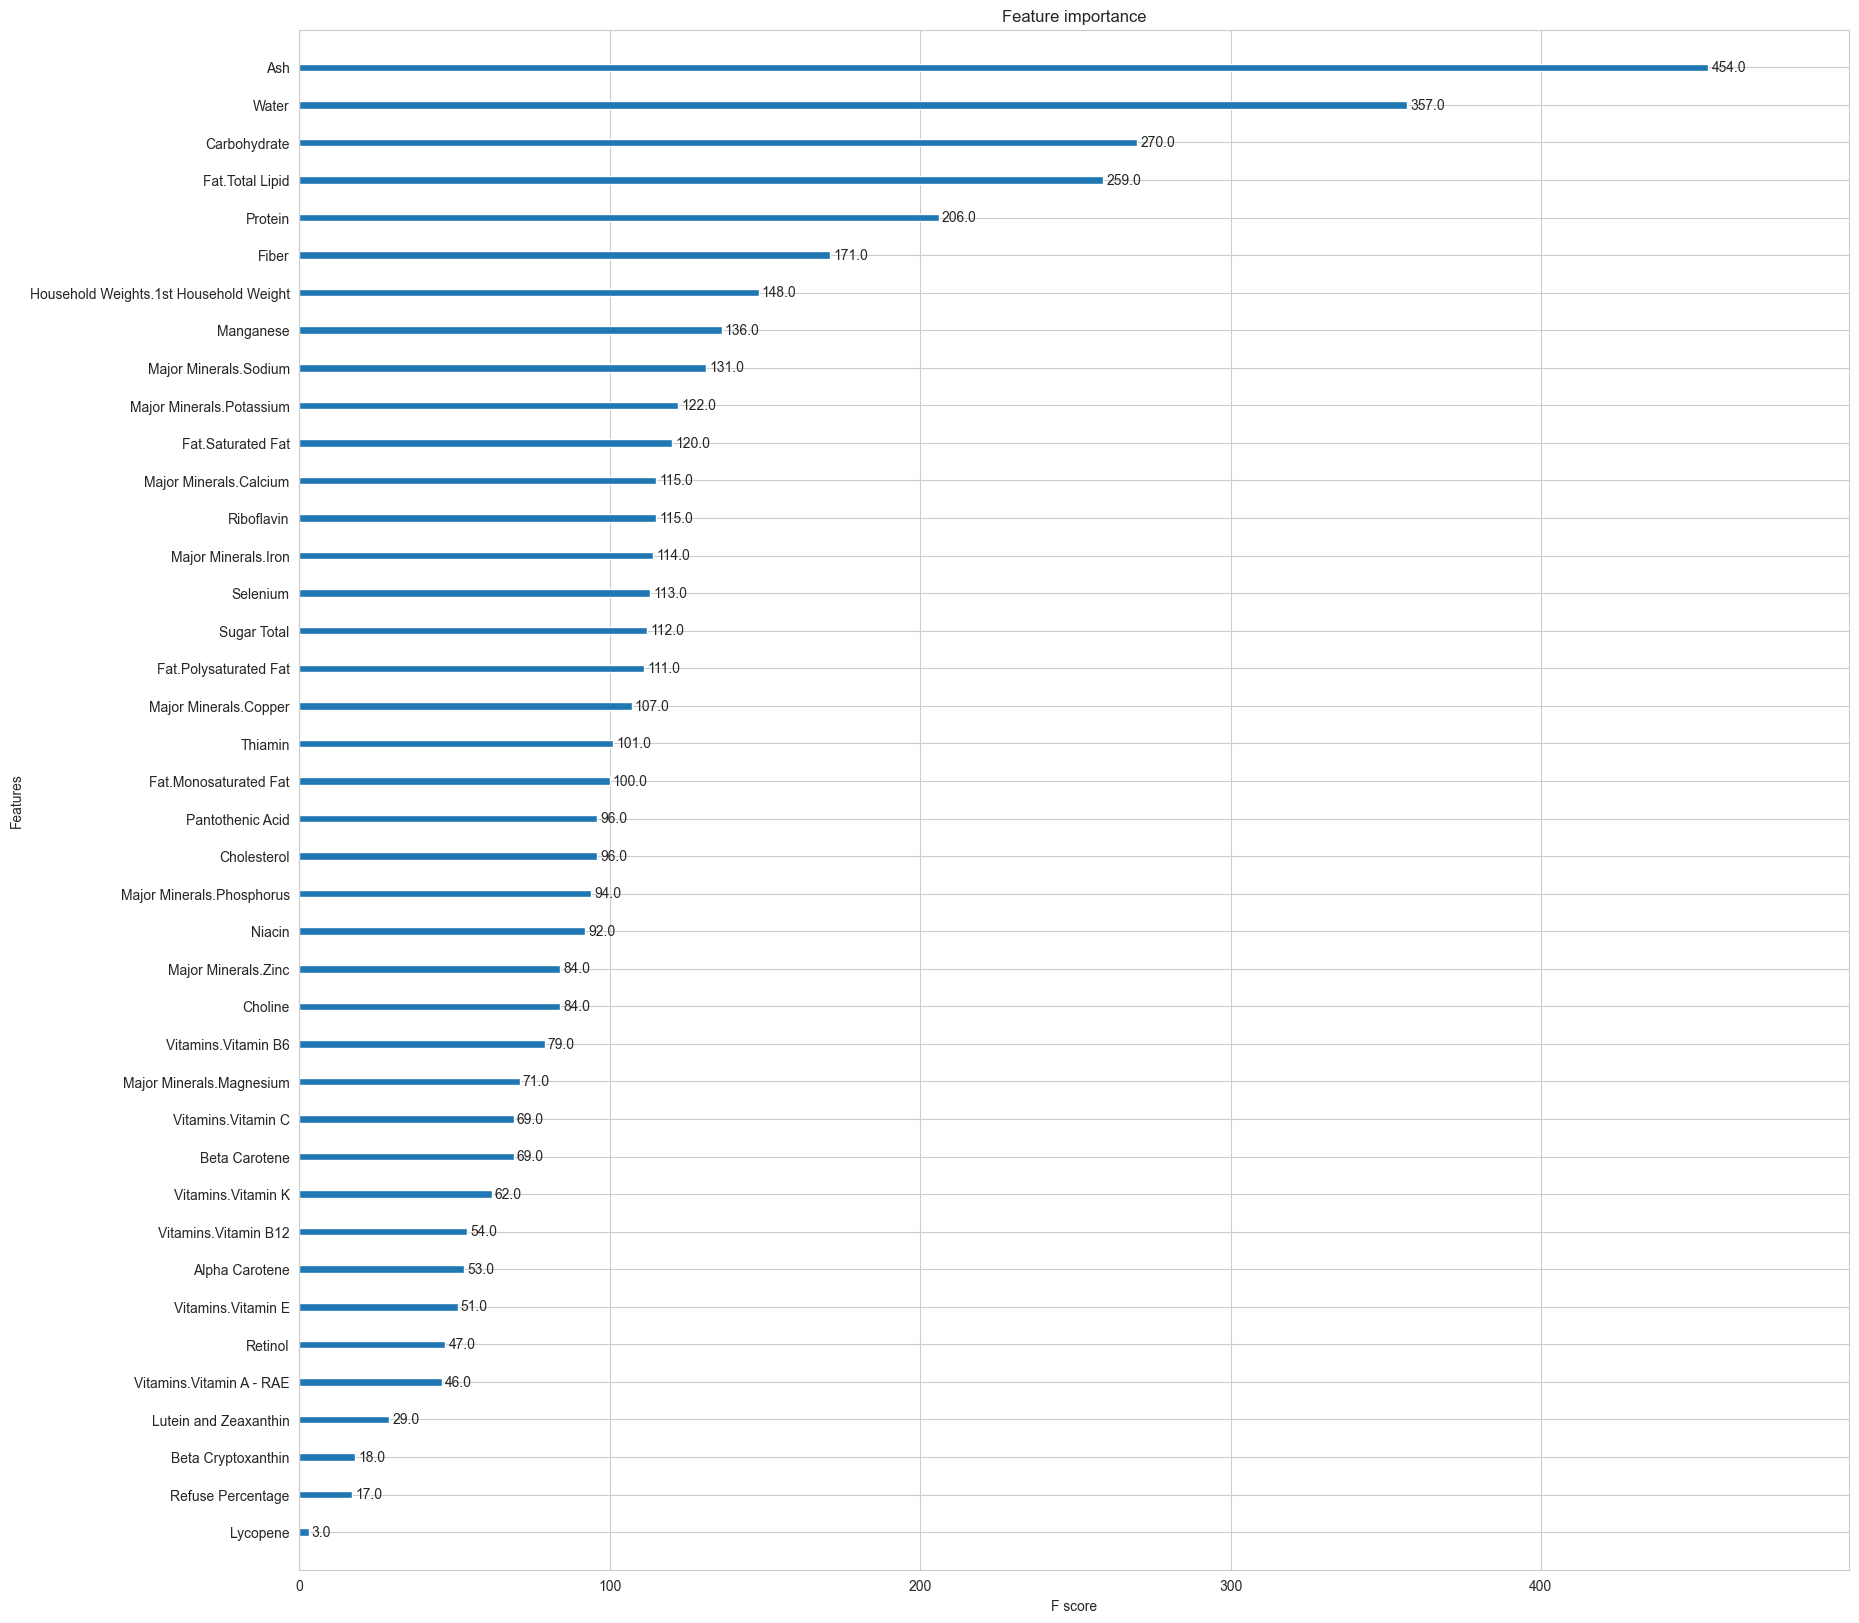

In [132]:
# Plot the variable importance
xgb.plot_importance(xgbm)

# Make the plot pretty
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

The variable importance plot above tells us that Fat.Total Lipid, Protein, and Carbohydrates are amongst our most important features, which is consistent with our findings from the OLS regression.

It's also interesting to see that Ash is leading the pack. This is really a misleading feature because it is a measure of the total amount of inorganic matter (e.g. minerals) within a food. This is not a good predictor of calories because minerals are not a source of calories. 

F Score here is calculated based on the number of times a variable is split on. This clearly isn't reliable because it is not a measure of how much a variable contributes to the model's accuracy. For example, if we were to split on Ash, we would be splitting on a feature that is not necessarily correlated with Kilocalories. 

## AutoML
Finally, let's use AutoML fit 20 models to our data and analyze the feature parameters of the best one by RMSE.

In [25]:
# Set up AutoML
aml = H2OAutoML(seed=1, max_models=20, stopping_metric='RMSE', sort_metric='RMSE', verbosity='info', exclude_algos = ["XGBoost", "DeepLearning"]) # Due to system limitations, I am only including specific algorithms that can run on my local machine for reproducibility

# Pass the data through H20AutoML set the seed for reproducibility
aml.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

AutoML progress: |
19:44:23.446: Project: AutoML_2_20231127_194423
19:44:23.447: 5-fold cross-validation will be used.
19:44:23.448: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:44:23.448: Setting stopping tolerance adaptively based on the training frame: 0.013401406685472435
19:44:23.448: Build control seed: 1
19:44:23.453: training frame: Frame key: AutoML_2_20231127_194423_training_py_2_sid_82c9    cols: 41    rows: 5568  chunks: 1    size: 527988  checksum: -5300609814215022100
19:44:23.454: validation frame: Frame key: py_3_sid_82c9    cols: 41    rows: 1375  chunks: 1    size: 127715  checksum: -9029090322467410074
19:44:23.454: leaderboard frame: NULL
19:44:23.454: blending frame: NULL
19:44:23.454: response column: Kilocalories
19:44:23.454: fold column: null
19:44:

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20231127_194423


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  6/20
# GBM base models (used / total)      5/17
# DRF base models (used / total)      0/2
# GLM base models (used / total)      1/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 25.11123569704341
RMSE: 5.0111112237749635
MAE: 2.76150371223653
RMSLE: 0.09310232794363825
Mean Residual Deviance: 25.11123569704341
R^2: 0.9991605345204537
Null degrees of freedom: 5567
Residual degrees of freedom: 5561
Null deviance: 166557605.72395822
Residual deviance: 139819.3603611377
AIC: 33764.71956003978

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 98.54234375079933
RMSE: 9.926849638772582
MAE: 4.9596407163489005
RMSLE: 0.05802528453250147
Mean Residual Deviance: 98.54234375079933
R^2: 0.9964648379877837
Null degrees of freedom: 1374
Residual degrees of freedom: 1368
Null deviance: 38329822.74758571
Residual deviance: 135495.72265734908
AIC: 10229.999686010835

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 120.87029345819234
RMSE: 10.99410266725722
MAE: 5.100254786695447
RMSLE: 0.12718811867738122
Mean Residual Deviance: 120.87029345819234
R^2: 0.9959593211546844
Null degrees of freedom: 5567
Residual degrees of freedom: 5560
Null deviance: 166560878.99013442
Residual deviance: 673005.7939752149
AIC: 42516.28941746994

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     5.09636      0.244413     5.09845       5.42636       4.76802       5.1999        4.98904
mean_residual_deviance  119.941      36.3797      127.195       173.283       81.1082       127.105       91.0162
mse                     119.941      36.3797      127.195       173.283       81.1082       127.105       91.0162
null_deviance           3.33122e+07  3.33434e+06  3.46674e+07   3.48833e+07   3.57129e+07   3.38277e+07   2.74695e+07
r2                      0.99598      0.00116718   0.995784      0.994312      0.99749       0.99578       0.996534
residual_deviance       134424       44288.6      146147        198409        89624.6       142739        95203
rmse                    10.8524      1.6456       11.2781       13.1637       9.00601       11.2741       9.54024
rmsle                   0.120992     0.0448694    0.182304      0.102053      0.1023        0.068498      0.149806

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [82]:
# Grab the best model that's not an ensemble (third row)
best_model = h2o.get_model(aml.leaderboard[2, 'model_id'])

# Print the model summary
best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20231127_194423_model_12


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    78                 78                          77648                  7            7            7             18            111           74.4103

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 22.34978380941068
RMSE: 4.727555796541241
MAE: 2.8756964385359622
RMSLE: 0.08732783479280788
Mean Residual Deviance: 22.34978380941068

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 110.66167932963978
RMSE: 10.51958551130413
MAE: 5.466168885125894
RMSLE: 0.062880389525823
Mean Residual Deviance: 110.66167932963978

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 129.50322063412068
RMSE: 11.37994818240051
MAE: 5.526512279857598
RMSLE: 0.12926408255235833
Mean Residual Deviance: 129.50322063412068

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     5.52277   0.339906    5.77444       5.73116       5.41782       4.97017       5.72025
mean_residual_deviance  129.495   34.4447     130.681       179.504       124.389       82.4166       130.485
mse                     129.495   34.4447     130.681       179.504       124.389       82.4166       130.485
r2                      0.995675  0.00112566  0.995854      0.994002      0.995739      0.997168      0.995614
residual_deviance       129.495   34.4447     130.681       179.504       124.389       82.4166       130.485
rmse                    11.2968   1.53223     11.4316       13.3979       11.153        9.07836       11.423
rmsle                   0.123644  0.0417985   0.156136      0.179683      0.0905142     0.10489       0.0869961

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-11-27 19:45:46  37.919 sec  0                  172.955          136.423         29913.4              166.962            134.729           27876.2
    2023-11-27 19:45:46  37.961 sec  5                  103.089          81.2661         10627.4              99.8072            80.3008           9961.48
    2023-11-27 19:45:46  38.026 sec  10                 61.9329          48.7109         3835.68              60.4715            48.3563           3656.81
    2023-11-27 19:45:46  38.089 sec  15                 37.6651          29.4654         1418.66              37.5426            29.7254           1409.45
    2023-11-27 19:45:46  38.131 sec  20                 23.6577          18.2041         559.686              24.6321            18.8083           606.741
    2023-11-27 19:45:46  38.161 sec  25                 15.6916          11.7088         246.228              17.696             12.6693           313.149
    2023-11-27 19:45:46  38.201 sec  30                 11.2243          7.95548         125.985              14.1045            9.23813           198.936
    2023-11-27 19:45:46  38.236 sec  35                 8.75058          5.83536         76.5726              12.3723            7.4198            153.073
    2023-11-27 19:45:46  38.266 sec  40                 7.46961          4.67672         55.7951              11.589             6.499

The best non-ensemble model is a Gradient Boosting Machine (GBM). Let's take a look at the visualizations of feature importance that H2O provides.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

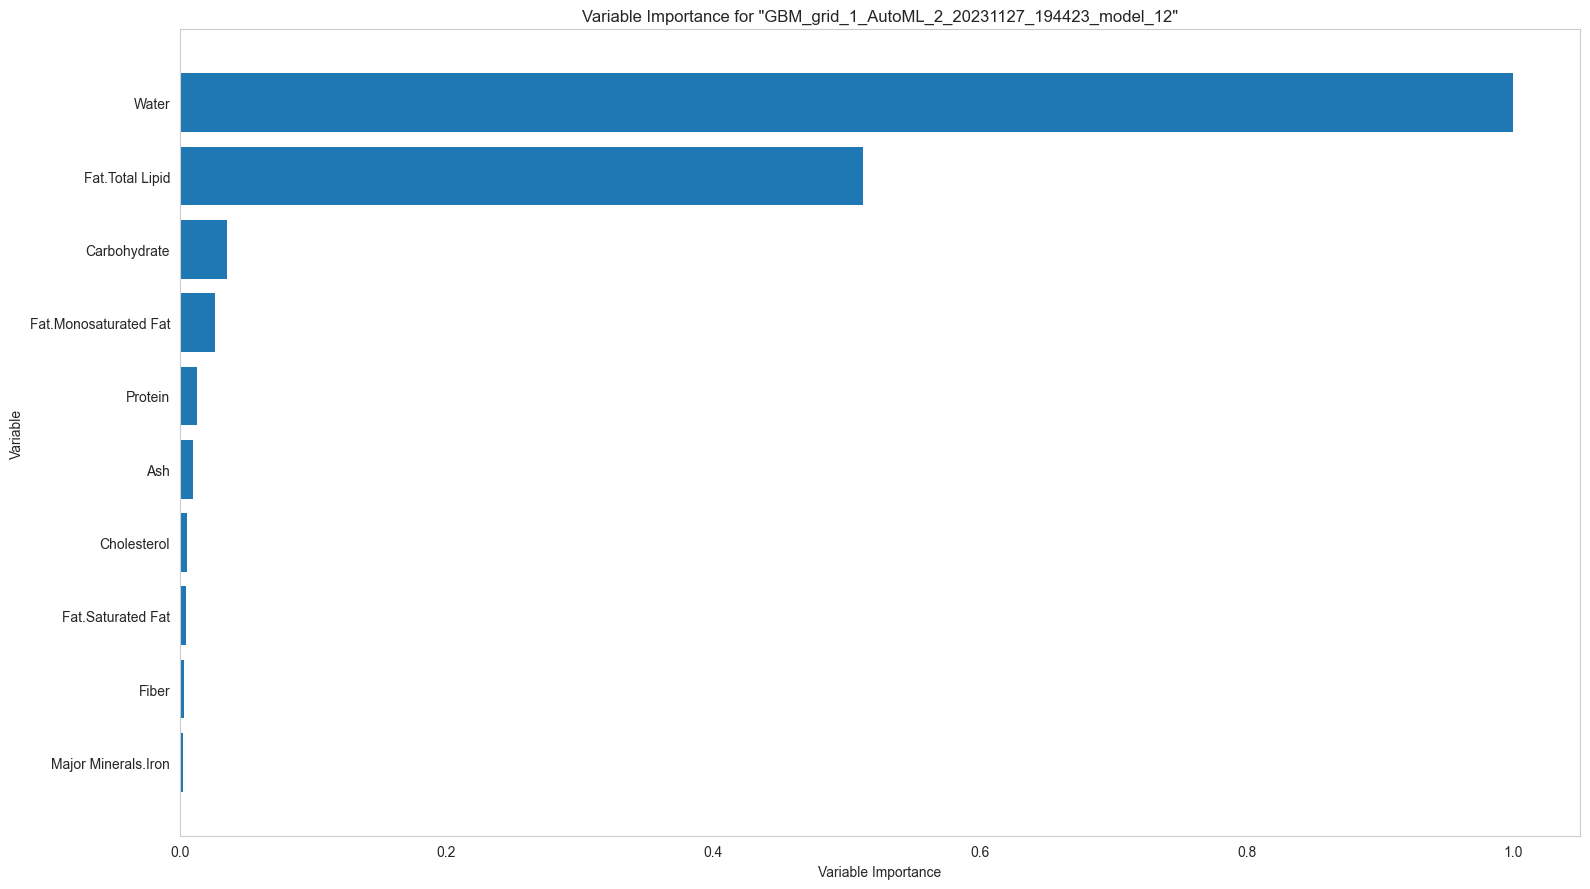

In [150]:
# Explain the best model
exm = best_model.explain(df_train, include_explanations=['varimp'])

It makes a lot of sense that water would be a strong predictor of kilocalories. Though we saw above in the OLS regression that it isn't strongly negatively correlated to the response, it is a significant predictor of the response. Water has 0 calories, so food with high water content will have fewer kilocalories. It does not make sense that it would be so much more significant than the other predictors like *Fat Total Lipids*, *Protein*, and *Carbohydrate*, which are essential building blocks of food.

Beyond that, I think this model overstates the importance of insignificant micronutrients like Potassium. Because *Water* is so significant, the model makes it seem like Potassium is as significant as Saturated Fat, which we know is not true. 

## Using SHAP to Compare Model Interpretability
Now that we have fit 3 models to our data, let's use the Shapley Additive Explanations (SHAP) method to understand what features are most important to each model. We will use the SHAP library to do this.

PermutationExplainer explainer: 5569it [05:25, 16.56it/s]                          


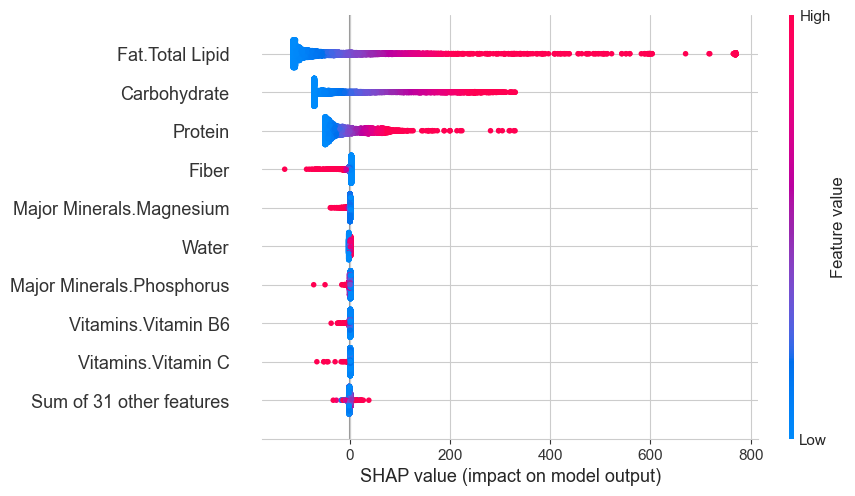

In [79]:
import shap

# Run Shap-ley Additive Explanations (SHAP) on the OLS Regression
explainer = shap.Explainer(lm.predict, df_train_pd[X])
shap_values = explainer(df_train_pd[X])

# Show Regression SHAP
shap.plots.beeswarm(shap_values)

The SHAP plot above shows us that macronutrients, Total Lipids, Carbohydrates, and Protein at low levels have a negative impact on kilocalories, and at high levels have a positive impact on kilocalories. This is consistent with our understanding of nutrition and our coefficient analysis above. 

Also in line with our regression, we can see an interesting phenomenon with fiber. At low levels, fiber has almost now impact on kilocalories, but at high levels, fiber has a strong negative impact on kilocalories. Again, because fiborous vegetables are low in calories.

Water, surprisingly, has close to no impact at any value.

PermutationExplainer explainer: 5569it [06:38, 13.51it/s]                          


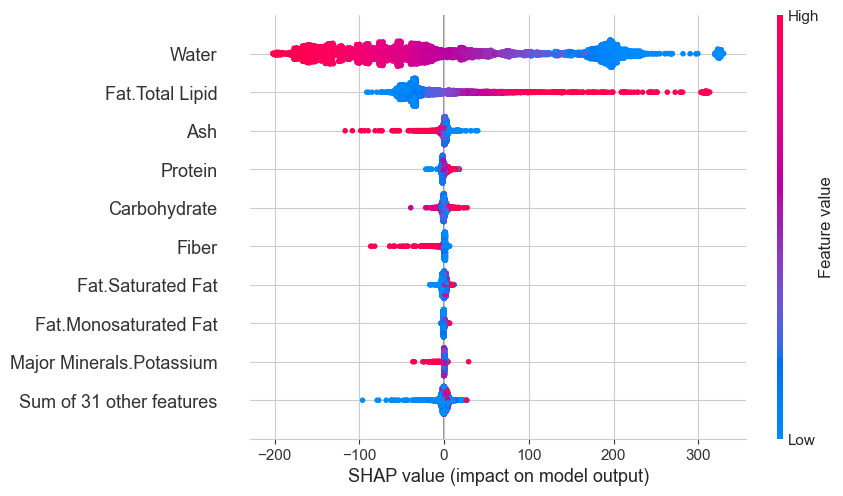

In [134]:
# Show Tree-Based model SHAP
explainer = shap.Explainer(xgbm.predict, df_train_pd[X])
shap_values = explainer(df_train_pd[X])

# Show Tree-Based model SHAP
shap.plots.beeswarm(shap_values)

This SHAP plot tells us a different story about Water. We can see here a clear negative correlation between Water and Kilocalories. We can see that foods with very low water content have a strong positive impact on kilocalories, and foods with very high water content have a strong negative impact on kilocalories. Foods with less water are more calorie dense, and foods with more water are less calorie dense. It's surprising that such a clear linear relationship was not found in the OLS regression.

This model again shows us that Fiber has a strong negative impact on kilocalories at high levels, but on average, doesn't matter much.

We can also see that high values o Ash has a strong positive impact on kilocalories. T

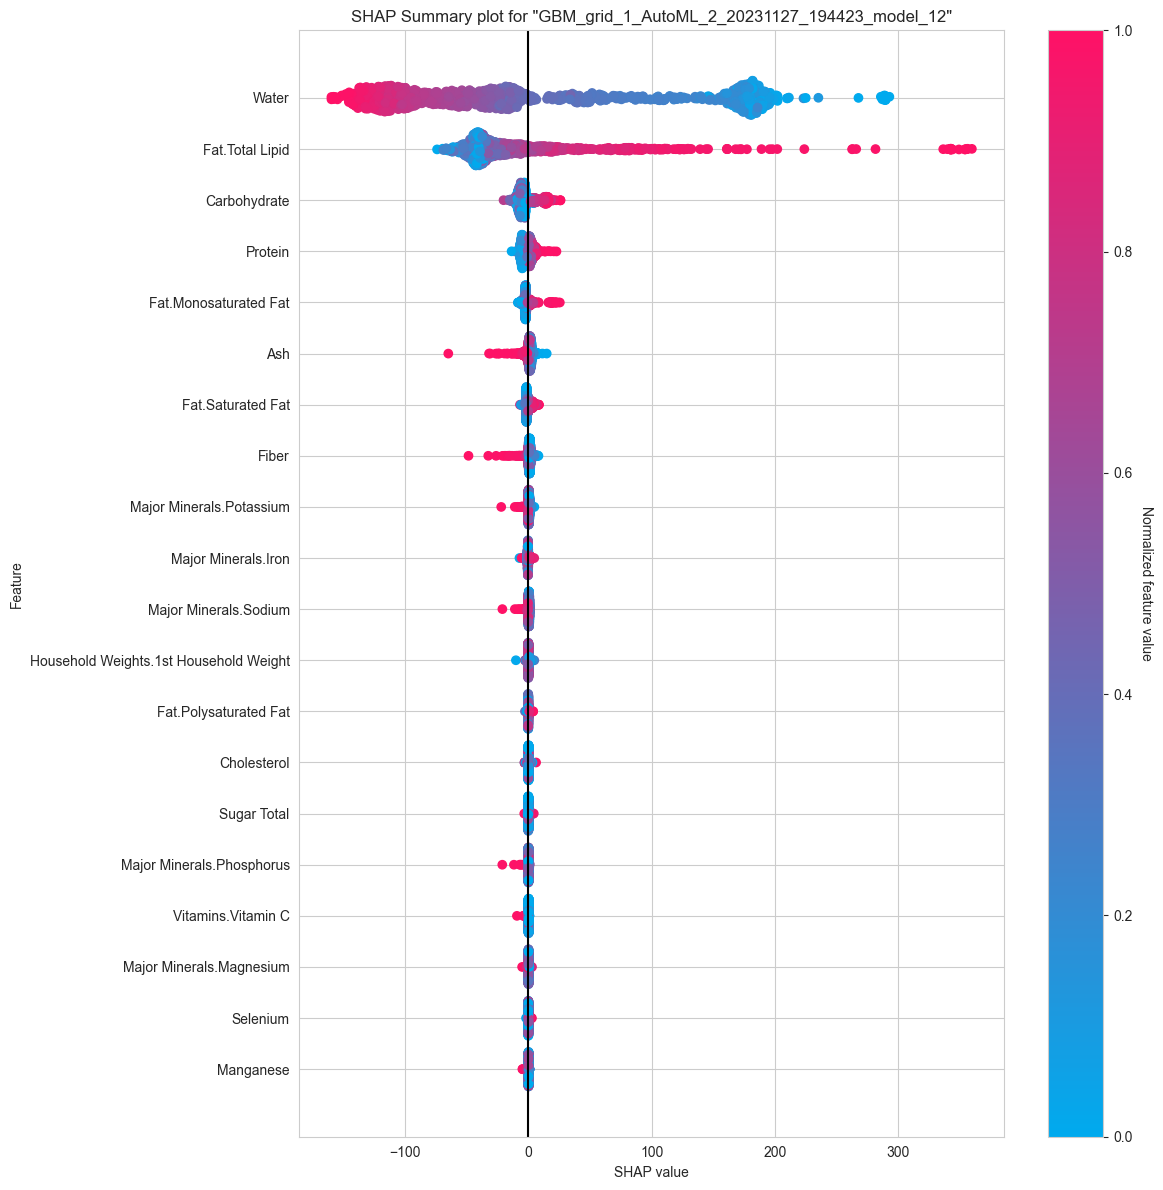

In [135]:
# Show the best AutoML model (GBM) SHAP
exm = best_model.shap_summary_plot(df_train)

## References
1. https://stackoverflow.com/questions/34218245/how-is-the-feature-score-importance-in-the-xgboost-package-calculated
2. 